# Задание 2. Замеры с $\texttt{MyPy}$, $\texttt{Cython}$ и $\texttt{Numba}$.
Проверим, насколько данные библиотеки ускорят работу функций, вычисляющих __числа Каталана__, определяющихся следующим образом:

$$С(n) = \begin{cases}
   1, & n = 0 \\
   \sum_{k=0}^{n-1} C(k)*C(n-k-1), & n > 0
\end{cases}$$

Будем сравнивать время работы _рекурсивного_ и _динамического_ алгоритмов.

### __ДИСКЛЕЙМЕР__:
При большинстве запусков 1-3 тесты были очень немонотонными, 4 чуть более плавным и 5 почти монотонным. Графики в гитхабе могут отличаться от тех, что были проанализированы.

#### Для начала добавим __таймер__:

In [12]:
import time


class Timer:
    def __init__(self, func):
        self.func = func

    def __call__(self, *args, **kwargs):
        tic = time.perf_counter()
        self.func(*args, **kwargs)
        toc = time.perf_counter()
        res = int((toc - tic) * 1000000000)
        return res

#### А также напишем функцию, которая будет строить __графики__, повышающие наглядность:

In [ ]:
pip install matplotlib

In [14]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use('ggplot')


def graphics(f, g, x):
    """
    f -- первая функция
    g -- вторая функция
    x -- область определения
    """

    """Сохраняем время работы каждой функции"""

    f_time = []
    g_time = []
    for i in range(x[0], x[-1] + 1):
        f_time.append(Timer(f)(i))
        g_time.append(Timer(g)(i))

    """Находим минимальное время"""

    min_time = []
    for i in range(len(f_time)):
        min_time.append((min(f_time[i], g_time[i])))

    """Настройки графиков"""

    my_figure = plt.figure(constrained_layout=True, figsize=(15, 5))
    grid_spec = plt.GridSpec(ncols=3, nrows=1, figure=my_figure)

    """График рекурсивного алгоритма"""

    graph_1 = my_figure.add_subplot(grid_spec[0, 0])
    plt.plot(x, f_time, '-o', color="red", label="Рекурсивный алгоритм")
    plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
    plt.legend()

    """График динамического алгоритма"""

    graph_2 = my_figure.add_subplot(grid_spec[0, 1])
    plt.plot(x, g_time, '-o', color="green", label="Динамический алгоритм")
    plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
    plt.legend()

    """График минимального времени"""

    graph_3 = my_figure.add_subplot(grid_spec[0, 2])
    plt.plot(x, min_time, '-o', color="black", label="Минимальное время")
    plt.legend()

    """Построение графиков и вывод минимального времени в консоль"""

    plt.show()
    print("Minimal time:", min(min_time), "ns\nMaximal time:", max(min_time), "ns")

## 1) Проверим, как работают алгоритмы __без ускорения__:

In [ ]:
pip install numpy

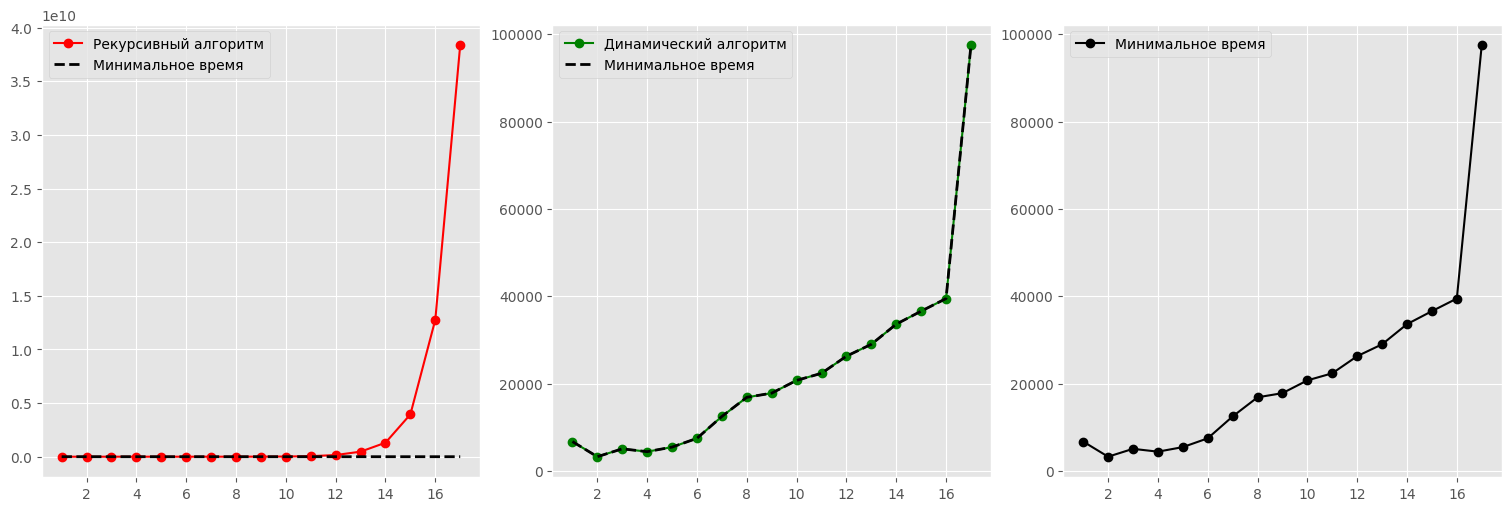

Minimal time: 3287 ns
Maximal time: 97501 ns


In [16]:
import numpy as np


"""Рекурсивный алгоритм"""

def catalan_recursive(n):
    if n == 0:
        return 1
    else:
        catalan = 0
        for i in range(n):
            catalan += catalan_recursive(i) * catalan_recursive(n - i - 1)
        return catalan


"""Динамический алгоритм"""

def catalan_dynamic(n):
    catalan = [0] * (n + 1)
    catalan[0] = 1
    for i in range(1, n + 1):
        for j in range(i):
            catalan[i] += catalan[j] * catalan[i - j - 1]
    return catalan[n]


x = np.r_[1:(17 + 1):1]
graphics(catalan_recursive, catalan_dynamic, x)

Отсюда видно, что _динамический_ алгоритм справляется лучше _рекурсивного_ для большинства протестированных чисел (при некоторых вызовах рекурсивный вычисляет первые числа Каталана быстрее).

Минимальное время в среднем находится в пределах __3000-100000 нс__ (пик был 449229 нс!).

Также следует обратить внимание на __скачки__ во времени работы функций и их немонотонный вид.

## 2) Протестируем $\texttt{Numba}$:

In [ ]:
pip install numba

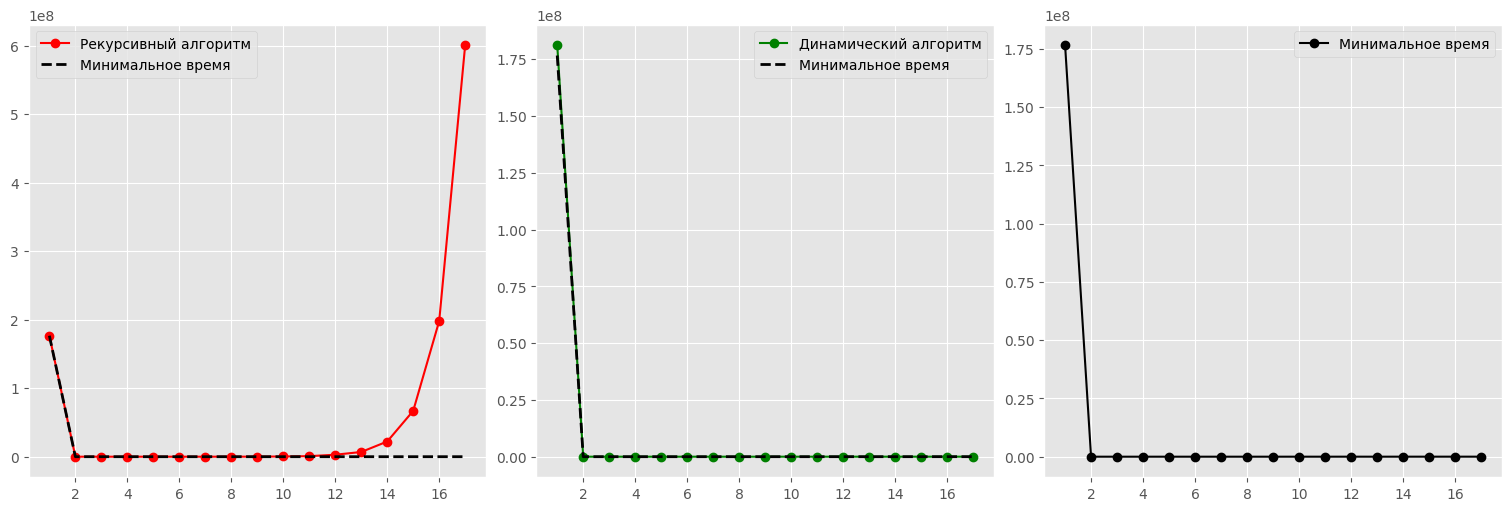

Minimal time: 649 ns
Maximal time: 176638151 ns


In [18]:
from numba import jit


"""Рекурсивный алгоритм"""

@jit
def catalan_recursive(n):
    if n == 0:
        return 1
    else:
        catalan = 0
        for i in range(n):
            catalan += catalan_recursive(i) * catalan_recursive(n - i - 1)
        return catalan


"""Динамический алгоритм"""

@jit
def catalan_dynamic(n):
    catalan = [0] * (n + 1)
    catalan[0] = 1
    for i in range(1, n + 1):
        for j in range(i):
            catalan[i] += catalan[j] * catalan[i - j - 1]
    return catalan[n]


graphics(catalan_recursive, catalan_dynamic, x)

Любопытно: минимум минимального времени составляет всего около __500 нс__, а вот максимум около целых __200 миллионов нс__, причём только на первом значении!

### 3) Попробуем учитывать первое число, которое так плохо вычисляет $\texttt{Numba}$:

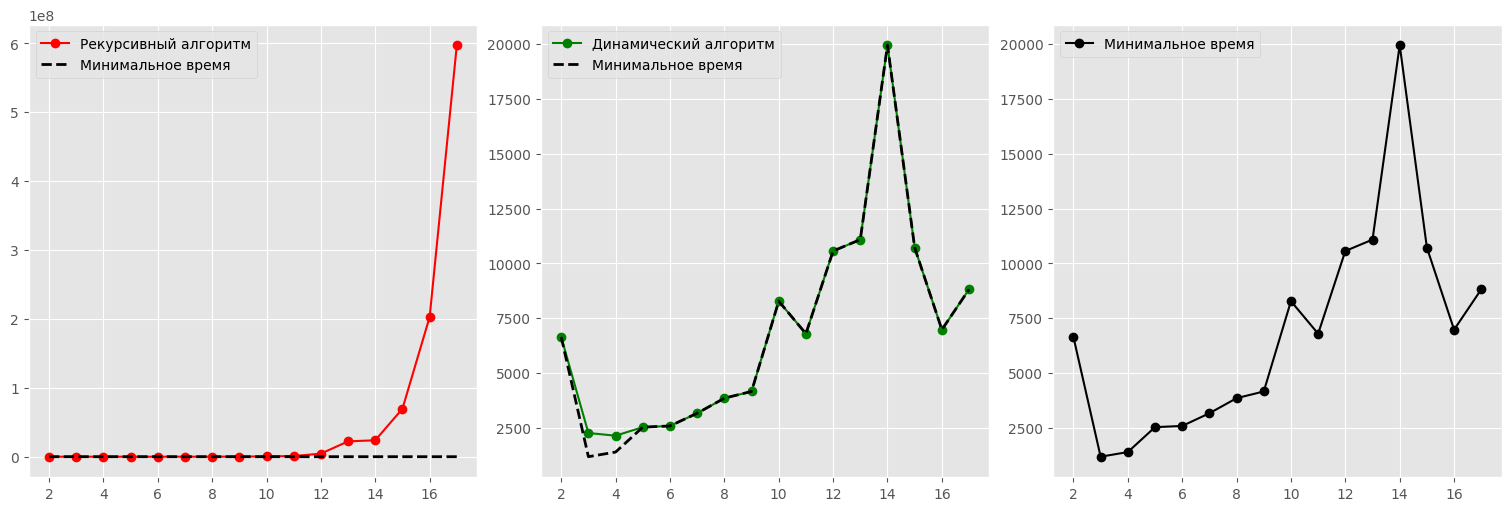

Minimal time: 1185 ns
Maximal time: 19956 ns


In [19]:
graphics(catalan_recursive, catalan_dynamic, x[1:])

Выходит, что $\texttt{Numba}$ значительно ускоряет работу обоих алгоритмов: __500-20000 нс__!

Однако немонотонный характер графиков сохраняется.

## 4) Теперь протестируем $\texttt{Cython}$.
Поскольку при использовании $\texttt{Cython}$ в Jupiter Notebook каждая ячейка блокнота компилируется и выполняется отдельно, придётся продублировать написанный ранее код здесь непосредственно:

In [ ]:
pip install cython

In [ ]:
%load_ext cython

In [22]:
%%cython


"""Импорт нужных библиотек"""

import time
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')


"""Таймер"""

class Timer:
    def __init__(self, func):
        self.func = func

    def __call__(self, *args, **kwargs):
        tic = time.perf_counter()
        self.func(*args, **kwargs)
        toc = time.perf_counter()
        res = int((toc - tic) * 1000000000)
        return res


"""Рекурсивный алгоритм"""

def catalan_recursive(n):
    if n == 0:
        return 1
    else:
        catalan = 0
        for i in range(n):
            catalan += catalan_recursive(i) * catalan_recursive(n - i - 1)
        return catalan


"""Динамический алгоритм"""

def catalan_dynamic(n):
    catalan = [0] * (n + 1)
    catalan[0] = 1
    for i in range(1, n + 1):
        for j in range(i):
            catalan[i] += catalan[j] * catalan[i - j - 1]
    return catalan[n]


"""Повышаем читаемость кода"""

f = catalan_recursive
g = catalan_dynamic
x = np.r_[1:(17 + 1):1]

"""Сохраняем время работы каждой функции"""

f_time = []
g_time = []
for i in range(x[0], x[-1] + 1):
    f_time.append(Timer(f)(i))
    g_time.append(Timer(g)(i))

"""Находим минимальное время"""

min_time = []
for i in range(len(f_time)):
    min_time.append((min(f_time[i], g_time[i])))

"""Настройки графиков"""

my_figure = plt.figure(constrained_layout=True, figsize=(15, 5))
grid_spec = plt.GridSpec(ncols=3, nrows=1, figure=my_figure)

"""График рекурсивного алгоритма"""

graph_1 = my_figure.add_subplot(grid_spec[0, 0])
plt.plot(x, f_time, '-o', color="red", label="Рекурсивный алгоритм")
plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
plt.legend()

"""График динамического алгоритма"""

graph_2 = my_figure.add_subplot(grid_spec[0, 1])
plt.plot(x, g_time, '-o', color="green", label="Динамический алгоритм")
plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
plt.legend()

"""График минимального времени"""

graph_3 = my_figure.add_subplot(grid_spec[0, 2])
plt.plot(x, min_time, '-o', color="black", label="Минимальное время")
plt.legend()

"""Построение графиков и вывод минимального времени в консоль"""

plt.show()
print("Minimal time:", min(min_time), "ns\nMaximal time:", max(min_time), "ns")

$\texttt{Cython}$ немного ускорил работу функий: максимум минимального времени теперь около 30000 нс вместо 100000 нс.

Графики всё ещё не монотонные.

## 5) Наконец, протестируем $\texttt{MyPy}$.
В этом случае придётся добавить аннотации типов к ранее написанному коду, сделав его статически типизированным:

In [ ]:
pip install mypy

In [ ]:
pip install mypy_ipython

In [ ]:
%load_ext mypy_ipython

Success: no issues found in 1 source file
Type checking successful


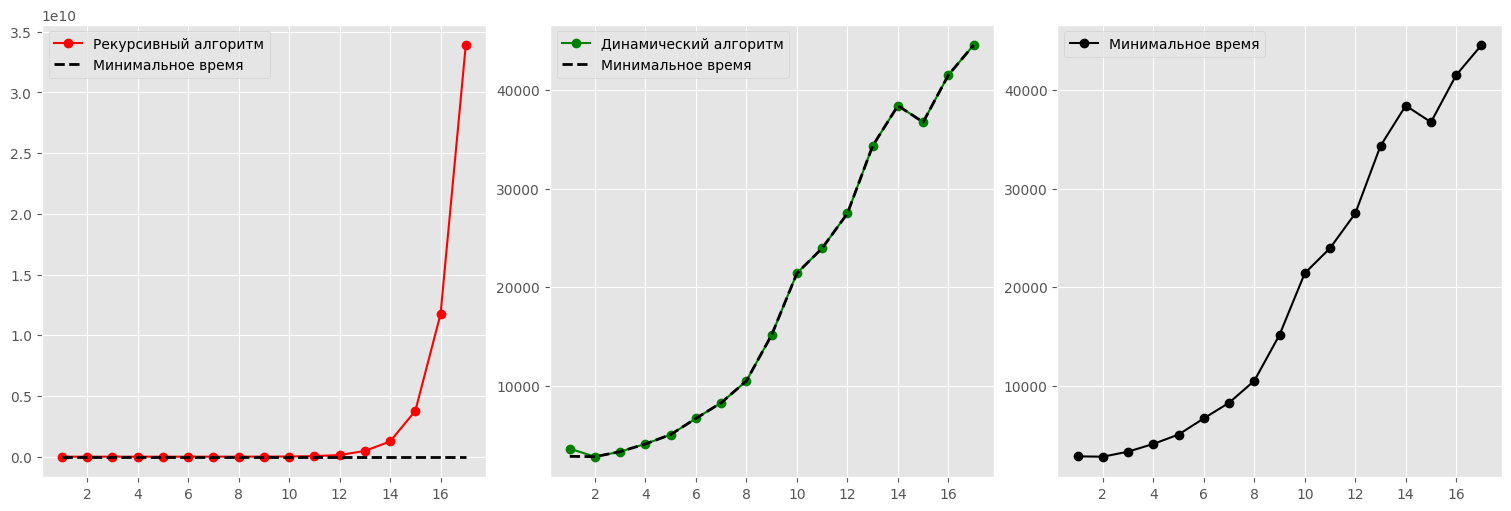

Minimal time: 2803 ns
Maximal time: 44586 ns


In [27]:
%mypy


"""Импорт нужных библиотек"""

import time
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from typing import Callable

style.use('ggplot')


"""Таймер"""

class Timer:
    def __init__(self, func) -> None:
        self.func = func

    def __call__(self, *args, **kwargs) -> int:
        tic: float = time.perf_counter()
        self.func(*args, **kwargs)
        toc: float = time.perf_counter()
        res = int((toc - tic) * 1000000000)
        return res


"""Рекурсивный алгоритм"""

def catalan_recursive(n: int) -> int:
    if n == 0:
        return 1
    else:
        catalan = 0
        for i in range(n):
            catalan += catalan_recursive(i) * catalan_recursive(n - i - 1)
        return catalan


"""Динамический алгоритм"""

def catalan_dynamic(n: int) -> int:
    catalan = [0] * (n + 1)
    catalan[0] = 1
    for i in range(1, n + 1):
        for j in range(i):
            catalan[i] += catalan[j] * catalan[i - j - 1]
    return catalan[n]


"""Повышаем читаемость кода"""

f: Callable[[int], int] = catalan_recursive
g: Callable[[int], int] = catalan_dynamic
x: list[int] = np.r_[1:(17 + 1):1]

"""Сохраняем время работы каждой функции"""

f_time: list[int] = []
g_time: list[int] = []
for i in range(x[0], x[-1] + 1):
    f_time.append(Timer(f)(i))
    g_time.append(Timer(g)(i))

"""Находим минимальное время"""

min_time: list[int] = []
for i in range(len(f_time)):
    min_time.append((min(f_time[i], g_time[i])))

"""Настройки графиков"""

my_figure = plt.figure(constrained_layout=True, figsize=(15, 5))
grid_spec = plt.GridSpec(ncols=3, nrows=1, figure=my_figure)

"""График рекурсивного алгоритма"""

graph_1 = my_figure.add_subplot(grid_spec[0, 0])
plt.plot(x, f_time, '-o', color="red", label="Рекурсивный алгоритм")
plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
plt.legend()

"""График динамического алгоритма"""

graph_2 = my_figure.add_subplot(grid_spec[0, 1])
plt.plot(x, g_time, '-o', color="green", label="Динамический алгоритм")
plt.plot(x, min_time, linestyle='--', linewidth=2, color="black", label="Минимальное время")
plt.legend()

"""График минимального времени"""

graph_3 = my_figure.add_subplot(grid_spec[0, 2])
plt.plot(x, min_time, '-o', color="black", label="Минимальное время")
plt.legend()

"""Построение графиков и вывод минимального времени в консоль"""

plt.show()
print("Minimal time:", min(min_time), "ns\nMaximal time:", max(min_time), "ns")

$\texttt{MyPy}$ удивляет! Сильно работу он не ускорил, зато почти __нивелировал скачки__ во времени. Теперь графики почти монотонные!